In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, Dense,Dropout,LSTM,Activation, RepeatVector, SimpleRNN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from datetime import datetime

import matplotlib.pyplot as plt

import os, glob


# Data Context

### The energy network of the Netherlands is managed by a few companies. The energy data is collected from following companies.

- Enexis
- Liander
- Stedin
- Enduris
- Westlandinfra
- Rendo
- Coteq

## 1st use-case
### Time-series analysis on electricity data from Stedin company

---------
## To understand data properly, we will need to introduce a year column into the dataset,
## since each file, states the data year, I will extract the year from the file and populate it with a separate column

In [3]:
years = ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
companies = ['stedin', 'liander','enduris', 'enexis','westland-infra','rendo','coteq'] 

In [4]:

path = r'../input/dutch-energy/Electricity/' 

stedin=[]
liander = []
enduris = []
enexis = []
westland_infra = []
rendo = []
coteq = []

for company in companies:
    all_files = glob.glob(f"{path}/{company}*.csv")
    for file in all_files:
        print(company, file)
        for year in years:
            if year in file:
                print(f"adding column year {year} to {file}")
        
                comp_df = company
                print(f"processing for : {comp_df}")
                comp_df = pd.read_csv(file, index_col=None, header=0)
                comp_df['year'] = year

                if company == companies[0]:
                    stedin.append(comp_df)

                elif company == companies[1]:
                    liander.append(comp_df)
                    
                elif company == companies[2]:
                        enduris.append(comp_df)
                        
                elif company == companies[3]:
                    enexis.append(comp_df)

                elif company == companies[4]:
                    westland_infra.append(comp_df)

                elif company == companies[5]:
                    rendo.append(comp_df)

                elif company == companies[6]:
                    coteq.append(comp_df)  


                
        print('-------------------------------')

        


stedin ../input/dutch-energy/Electricity/stedin_electricity_2017.csv
adding column year 2017 to ../input/dutch-energy/Electricity/stedin_electricity_2017.csv
processing for : stedin
-------------------------------
stedin ../input/dutch-energy/Electricity/stedin_electricity_2019.csv
adding column year 2019 to ../input/dutch-energy/Electricity/stedin_electricity_2019.csv
processing for : stedin
-------------------------------
stedin ../input/dutch-energy/Electricity/stedin_electricity_2011.csv
adding column year 2011 to ../input/dutch-energy/Electricity/stedin_electricity_2011.csv
processing for : stedin
-------------------------------
stedin ../input/dutch-energy/Electricity/stedin_electricity_2010.csv
adding column year 2010 to ../input/dutch-energy/Electricity/stedin_electricity_2010.csv
processing for : stedin
-------------------------------
stedin ../input/dutch-energy/Electricity/stedin_electricity_2015.csv
adding column year 2015 to ../input/dutch-energy/Electricity/stedin_electri

In [5]:
stedin_df = pd.concat(stedin, axis=0, ignore_index=True)
# liander_df = pd.concat(liander, axis=0, ignore_index=True)
# enduris_df = pd.concat(enduris, axis=0, ignore_index=True)
# enexis_df = pd.concat(enexis, axis=0, ignore_index=True)
# westland_infra_df = pd.concat(westland_infra, axis=0, ignore_index=True)
# rendo_df = pd.concat(rendo, axis=0, ignore_index=True)
# coteq_df = pd.concat(coteq, axis=0, ignore_index=True)

In [6]:
stedin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999434 entries, 0 to 999433
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   net_manager                   999434 non-null  int64  
 1   purchase_area                 999434 non-null  object 
 2   street                        999434 non-null  object 
 3   zipcode_from                  999434 non-null  object 
 4   zipcode_to                    999434 non-null  object 
 5   city                          999434 non-null  object 
 6   num_connections               999434 non-null  int64  
 7   delivery_perc                 999434 non-null  float64
 8   perc_of_active_connections    999434 non-null  float64
 9   type_conn_perc                999434 non-null  float64
 10  type_of_connection            999434 non-null  object 
 11  annual_consume                999434 non-null  float64
 12  annual_consume_lowtarif_perc  999434 non-nul

In [7]:
stedin_df.isna().sum()

net_manager                          0
purchase_area                        0
street                               0
zipcode_from                         0
zipcode_to                           0
city                                 0
num_connections                      0
delivery_perc                        0
perc_of_active_connections           0
type_conn_perc                       0
type_of_connection                   0
annual_consume                       0
annual_consume_lowtarif_perc         0
smartmeter_perc                      0
year                                 0
STANDAARDDEVIATIE               913096
dtype: int64

In [8]:
stedin_df = stedin_df.drop('STANDAARDDEVIATIE', 1)

In [9]:
stedin_df.head(5)

,net_manager,purchase_area,street,zipcode_from,zipcode_to,city,num_connections,delivery_perc,perc_of_active_connections,type_conn_perc,type_of_connection,annual_consume,annual_consume_lowtarif_perc,smartmeter_perc,year
0,8716874000009,Stedin Utrecht,Gijsbrecht van Amstelln,1181EJ,1231AB,AMSTELVEEN,33,96.97,90.91,79.0,3x25,5203.0,81.82,9.09,2017
1,8716874000009,Stedin Utrecht,Rembrandtlaan,1231AC,1231AC,LOOSDRECHT,17,100.00,100.00,41.0,1x25,3181.0,76.47,17.65,2017
2,8716874000009,Stedin Utrecht,Rembrandtlaan,1231AD,1231AD,LOOSDRECHT,17,100.00,100.00,47.0,3x25,3717.0,76.47,5.88,2017
3,8716874000009,Stedin Utrecht,Jan Steenlaan,1231AE,1231AE,LOOSDRECHT,20,100.00,100.00,45.0,3x25,4644.0,85.00,15.00,2017
4,8716874000009,Stedin Utrecht,Pieter de Hooghlaan,1231AG,1231AG,LOOSDRECHT,17,100.00,100.00,71.0,1x25,3526.0,64.71,0.00,2017


In [10]:
stedin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999434 entries, 0 to 999433
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   net_manager                   999434 non-null  int64  
 1   purchase_area                 999434 non-null  object 
 2   street                        999434 non-null  object 
 3   zipcode_from                  999434 non-null  object 
 4   zipcode_to                    999434 non-null  object 
 5   city                          999434 non-null  object 
 6   num_connections               999434 non-null  int64  
 7   delivery_perc                 999434 non-null  float64
 8   perc_of_active_connections    999434 non-null  float64
 9   type_conn_perc                999434 non-null  float64
 10  type_of_connection            999434 non-null  object 
 11  annual_consume                999434 non-null  float64
 12  annual_consume_lowtarif_perc  999434 non-nul

### Let's focus on the first top 10 cities based on their annual electricity consumption

In [11]:
top_10_cities = stedin_df['city'].value_counts().sort_values(ascending = False).nlargest(10)

In [12]:
top_10_df = stedin_df[stedin_df['city'].isin(top_10_cities.index)] 

In [13]:
top_10_df.head(2)

,net_manager,purchase_area,street,zipcode_from,zipcode_to,city,num_connections,delivery_perc,perc_of_active_connections,type_conn_perc,type_of_connection,annual_consume,annual_consume_lowtarif_perc,smartmeter_perc,year
187,8716892000005,Stedin Utrecht,Van Dorpstraat gesloopt,1234AB,1234AB,ROTTERDAM,16,100.0,12.50,44.0,1x35,5541.0,100.00,6.25,2017
4177,8716921000006,Stedin Midden-Holland,Rijswijkse Waterweg,2400ZZ,2411AA,'S-GRAVENHAGE,16,100.0,93.75,50.0,3x25,18935.0,93.75,12.50,2017


In [14]:
pd.DataFrame(top_10_df.year.value_counts())

,year
2020,42859
2018,42294
2017,41613
2016,41427
2015,41258
2014,41097
2012,41055
2019,40930
2013,40911
2011,40879


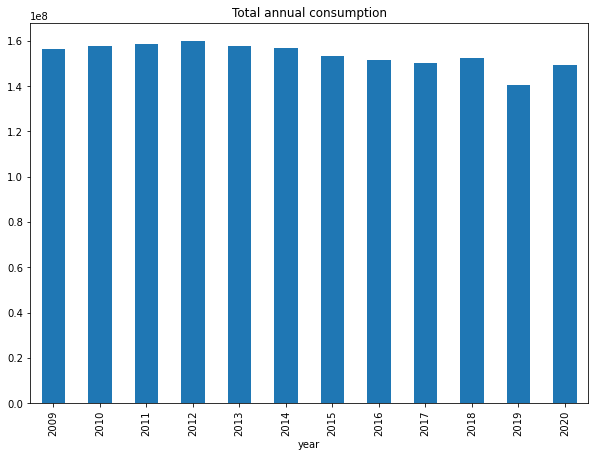

In [15]:
fig, ax = plt.subplots(figsize=(10,7))
top_10_df.groupby(['year'])['annual_consume'].sum().plot(kind = 'bar', ax=ax, title = 'Total annual consumption')

### Total consumption among 10 cities shows a slight decrease in year 2019
-------

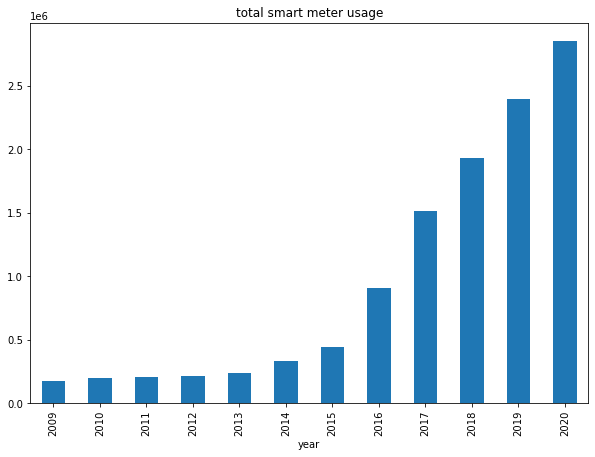

In [16]:
fig, ax = plt.subplots(figsize=(10,7))
top_10_df.groupby(['year'])['smartmeter_perc'].sum().plot(kind = 'bar', ax=ax, title = 'total smart meter usage')

### over time the smart meter usage kept on increasing since 2015 and within last 5 year it has shown an exponential growth

-----------

### total consumption per connection in top 10 cities

In [17]:
top_10_df['consumption_per_connection'] = top_10_df['annual_consume'] / (top_10_df['num_connections'] * top_10_df['perc_of_active_connections'] / 100)
top_10_df.loc[top_10_df['consumption_per_connection'] == np.inf, 'consumption_per_connection'] = 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


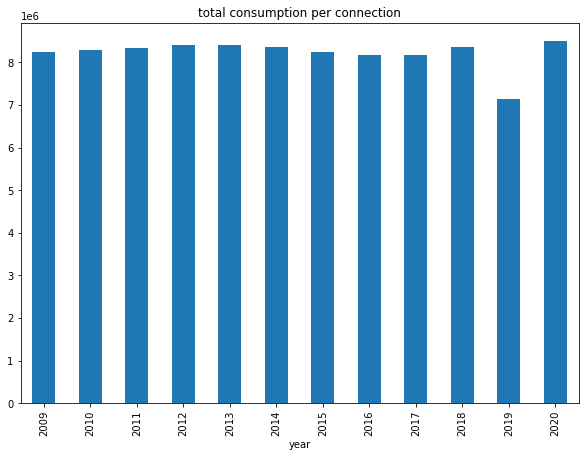

In [18]:
cpc = top_10_df.groupby(['year'])['consumption_per_connection'].sum()
cpc.plot(kind='bar', title= 'total consumption per connection', figsize=(10, 7))

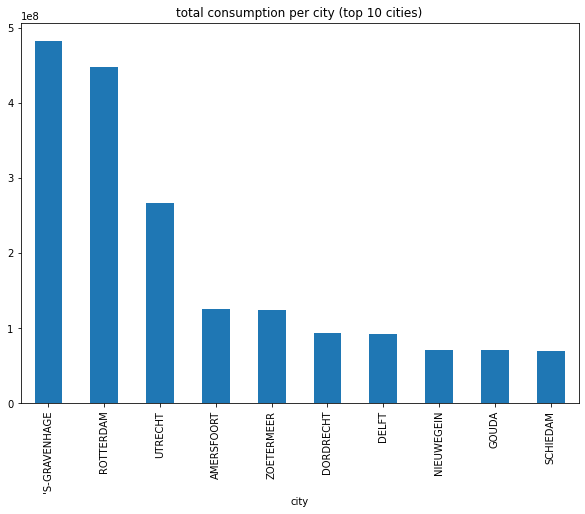

In [19]:
city_conumption = top_10_df.groupby(['city'])['annual_consume'].sum().sort_values(ascending=False).head(10)
city_conumption.plot(kind='bar', title= 'total consumption per city (top 10 cities)', figsize=(10, 7))

### the graph shows first 3 cites have a huge consumption rate while in remaming cities the rate is pretty much low.
--------

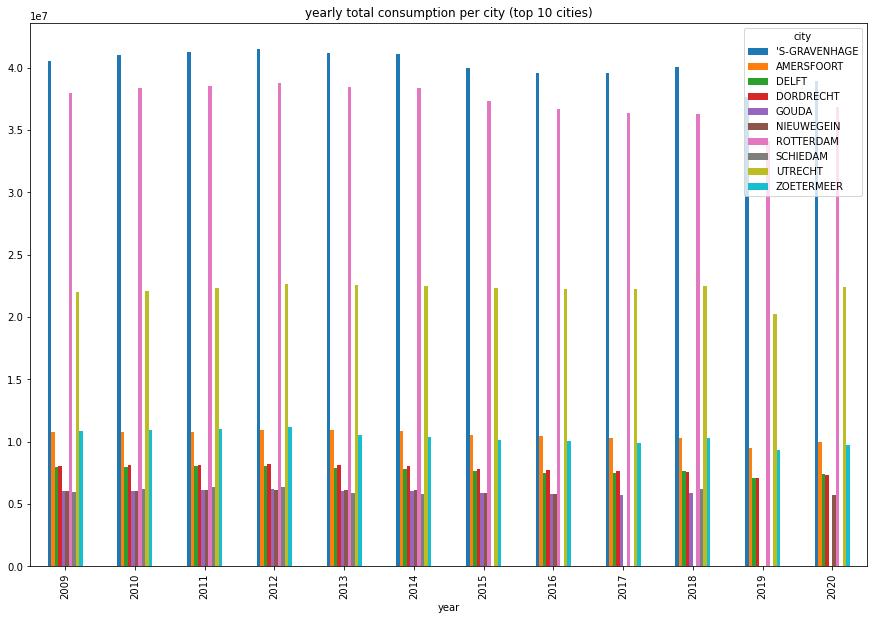

In [20]:
t1c_ac = top_10_df.groupby(['year','city'])['annual_consume'].sum().sort_values(ascending = False).head(110)
t1c_ac.unstack().plot(kind='bar', title= 'yearly total consumption per city (top 10 cities)', figsize=(15, 10))

----------
## top 10 cites that uses smart meter more often

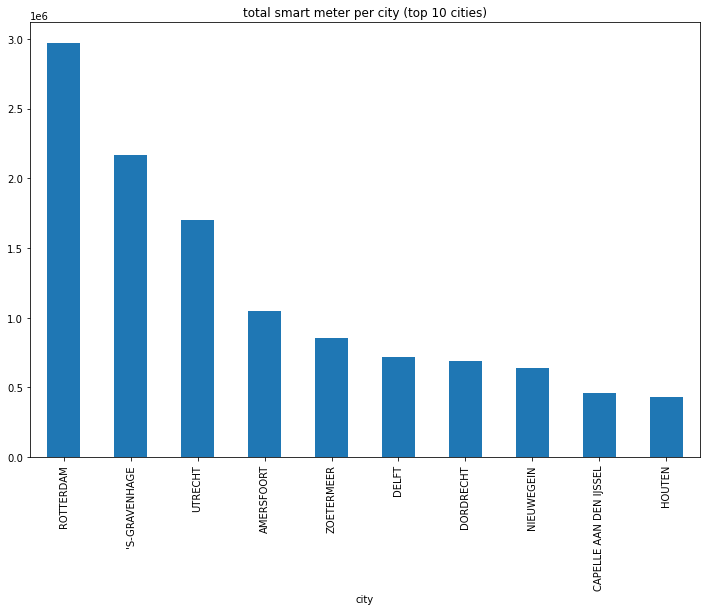

In [22]:
top_10_cities_sm=stedin_df.groupby(['city'])['smartmeter_perc'].sum().sort_values(ascending = False).head(10)
top_10_cities_sm.plot(kind='bar', title= 'total smart meter per city (top 10 cities)', figsize=(12, 8))

In [23]:
sm_10_df = stedin_df[stedin_df['city'].isin(top_10_cities_sm.index)] 

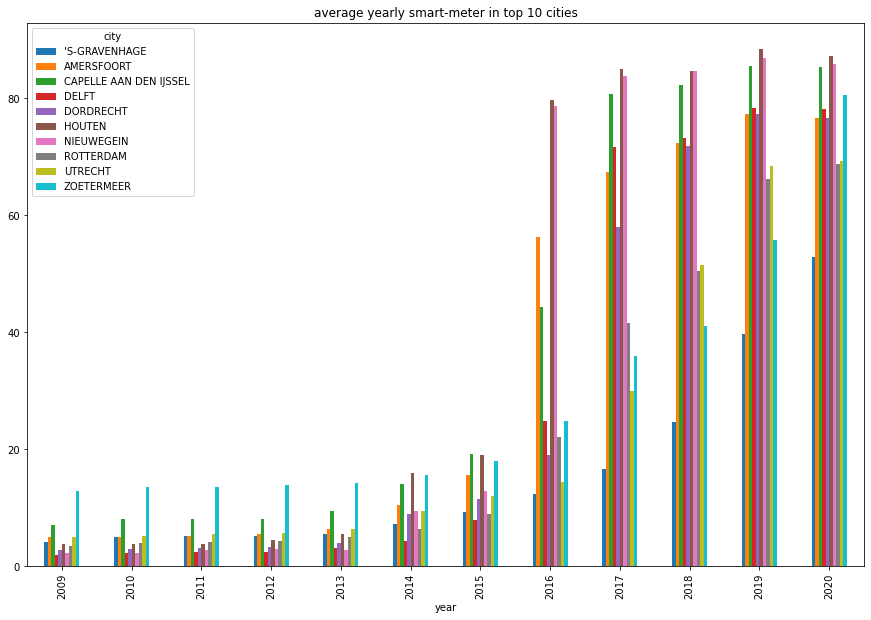

In [24]:
top_10_sm_yearly = sm_10_df.groupby(['year','city'])['smartmeter_perc'].mean().sort_values(ascending = False)
top_10_sm_yearly.unstack().plot(kind='bar', title= 'average yearly smart-meter in top 10 cities', figsize=(15, 10))

## Time series analysis

In [25]:
stedin_df.annual_consume.sort_values(ascending = True)

285778         0.0
327719         0.0
532121         0.0
230219         0.0
560003         0.0
            ...   
621125    105830.0
289055    105830.0
539255    110560.0
561225    110756.0
532719    110857.0
Name: annual_consume, Length: 999434, dtype: float64

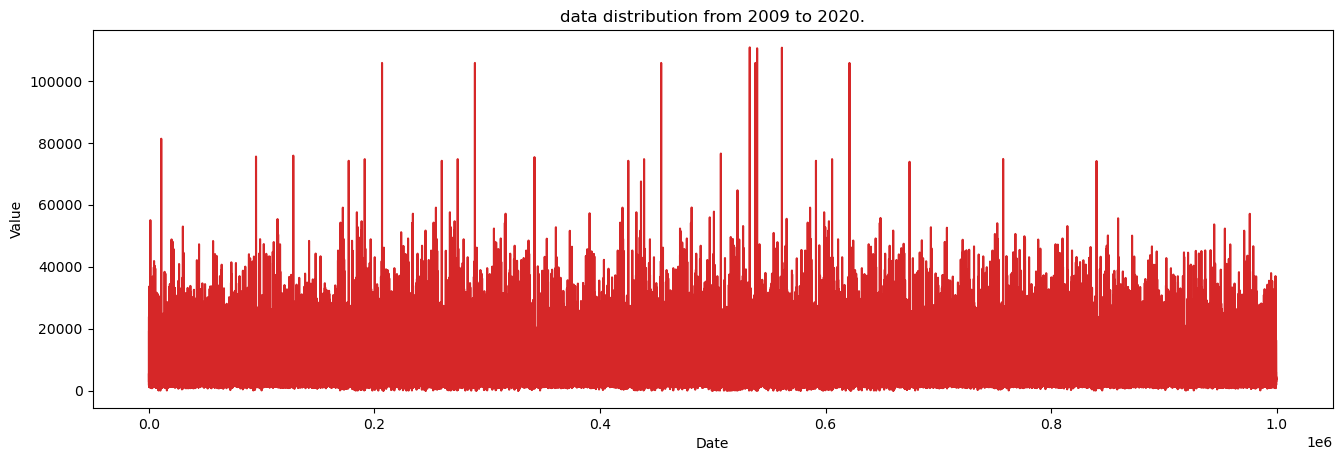

In [26]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(stedin_df, x=stedin_df.index, y=stedin_df.annual_consume, title='data distribution from 2009 to 2020.')    

In [27]:
dataset = stedin_df.annual_consume.values.reshape(-1,1)

sclar = MinMaxScaler(feature_range=(0,1))
dataset = sclar.fit_transform(dataset)
dataset.shape

(999434, 1)

In [28]:
def load_data(dataset, seq_len):
    X_train = []
    y_train = []
    split_size = int(0.8 * len(dataset))
    
    for i in range(seq_len, len(dataset)):
        X_train.append(dataset[i - seq_len: i, 0])
        y_train.append(dataset[i, 0])

   
    X_test = X_train[split_size:]
    y_test = y_train[split_size:]

   
    X_train = X_train[:split_size]
    y_train = y_train[:split_size]

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return [X_train, y_train, X_test, y_test]

In [29]:
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(dataset, seq_len)

X_train = X_train.reshape(X_train.shape[0], seq_len, 1)
X_test = X_test.reshape(X_test.shape[0], seq_len, 1)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((799547, 20, 1), (199867, 20, 1), (799547,), (199867,))

In [33]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1))))
model.add(Bidirectional(LSTM(64,return_sequences= False, activation= 'relu')))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(loss='mse', optimizer = 'adam')
hist = model.fit(X_train, y_train, epochs=5, validation_split=0.3, batch_size=1024)
model.summary()

Train on 559682 samples, validate on 239865 samples
Epoch 1/5
559682/559682 [==============================] - 27s 48us/sample - loss: 7.4500e-04 - val_loss: 7.2503e-04
Epoch 2/5
559682/559682 [==============================] - 23s 41us/sample - loss: 6.9700e-04 - val_loss: 7.1445e-04
Epoch 3/5
559682/559682 [==============================] - 24s 43us/sample - loss: 6.9417e-04 - val_loss: 7.2714e-04
Epoch 4/5
559682/559682 [==============================] - 22s 40us/sample - loss: 6.9176e-04 - val_loss: 7.0924e-04
Epoch 5/5
559682/559682 [==============================] - 24s 42us/sample - loss: 6.9183e-04 - val_loss: 7.1005e-04
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection multiple                  33792     
_________________________________________________________________
bidirectional_7 (Bidirection multiple                  98816     
___________

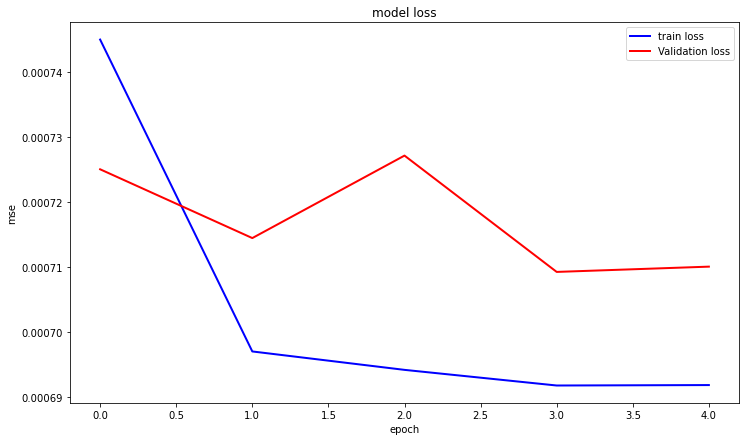

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(hist.history['loss'], 'b' ,label = 'train loss', linewidth=2)
ax.plot(hist.history['val_loss'], 'r', label ='Validation loss', linewidth=2)
ax.set_title('model loss')
ax.set_ylabel('mse')
ax.set_xlabel('epoch')
ax.legend()
plt.show()

In [37]:
pred = model.predict(X_test)

In [91]:
y_test_in.shape

(1, 199867)

In [47]:
def eval_score(y_test, y_true):
    mae = mean_absolute_error(y_test, y_true)
    mse = mean_squared_error(y_test, y_true)
     
    
    return f"mae : {mae}, mse : {mse}"

In [96]:
eval_score(y_test, pred)

'mae : 0.013277448535172579, mse : 0.0006535335263524865'

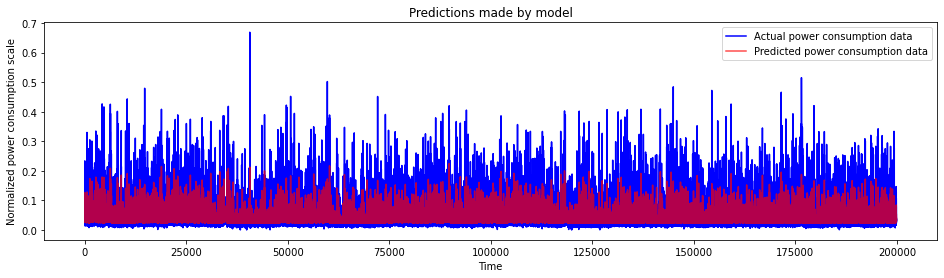

In [98]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16, 4))
    plt.plot(test, color='blue', label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='red', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()


plot_predictions(y_test, pred, "Predictions made by model")